<a href="https://colab.research.google.com/github/philippOkie/flowers-classifier/blob/main/flowers_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 740.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.3 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
from fastai.vision.all import download_images, get_image_files, verify_images
import requests

In [ ]:
API_KEY = "API_KEY"
BASE_URL = "https://pixabay.com/api/"

In [ ]:
def fetch_pixabay_urls(query, per_page=200, page=1):
    params = {
        "key":    API_KEY,
        "q":      query,
        "image_type": "photo",
        "per_page":   per_page,
        "page":       page
    }
    r = requests.get(BASE_URL, params=params)
    r.raise_for_status()
    data = r.json()
    return [hit['largeImageURL'] for hit in data.get('hits', [])]

urls = fetch_pixabay_urls("rose", per_page=100)
print(f"Got {len(urls)} rose URLs")

Got 100 rose URLs


In [ ]:
flower_types = ['rose', 'tulip', 'daisy']
root = Path('flowers')
root.mkdir(parents=True, exist_ok=True)

for flower in flower_types:
    dest = Path('flowers')/flower
    urls = fetch_pixabay_urls(flower, per_page=200)
    download_images(dest, urls=urls)

all_files = get_image_files('flowers')
failed = verify_images(all_files)
for f in failed: f.unlink()
print(f"Downloaded {len(get_image_files('flowers'))} valid images")

Downloaded 639 valid images


In [ ]:
# Script to get more images of a particular type
flower_to_add = 'daisy' # choose flower to add here
dest_to_add = Path('flowers')/flower_to_add

urls_to_add = fetch_pixabay_urls(flower_to_add, per_page=200)
download_images(dest_to_add, urls=urls_to_add)

all_files = get_image_files('flowers')
failed = verify_images(all_files)
for f in failed: f.unlink()
print(f"Downloaded {len(get_image_files('flowers'))} valid images")

Downloaded 839 valid images


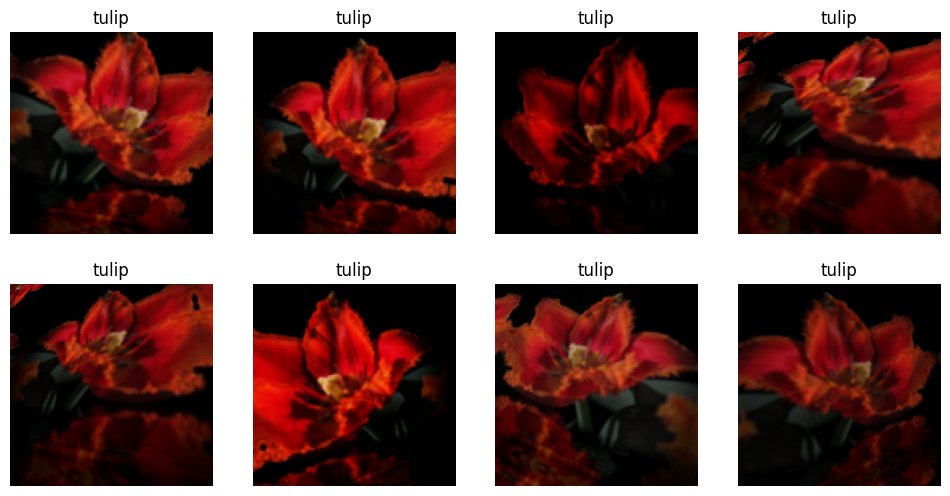

In [ ]:
from fastai.vision.all import cnn_learner, resnet34, error_rate, DataBlock, ImageBlock, CategoryBlock, RandomSplitter, parent_label, Resize, aug_transforms

flowers = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label
)

flowers = flowers.new(
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(mult=2)
)

path = Path('flowers')

dls = flowers.dataloaders(path)

dls.train.show_batch(
    max_n=8,
    nrows=2,
    unique=True
)

In [ ]:
from fastai.vision.all import resnet18

learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.643770,0.528897,0.185629,00:57


epoch,train_loss,valid_loss,error_rate,time
0,0.802301,0.434301,0.155689,01:23
1,0.699582,0.322518,0.119760,01:15
2,0.576465,0.304519,0.143713,01:15
3,0.495381,0.288461,0.143713,01:15


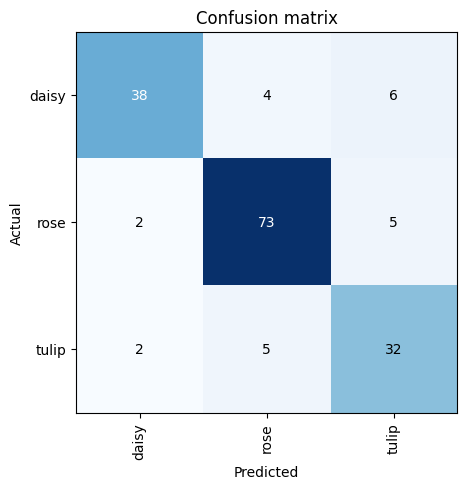

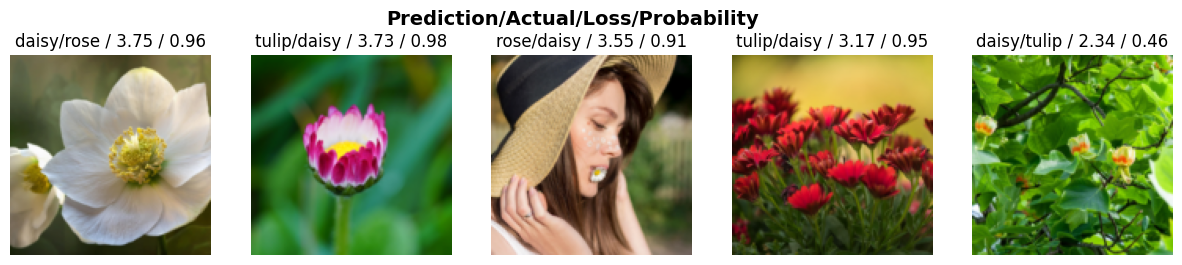

In [ ]:
from fastai.vision.all import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

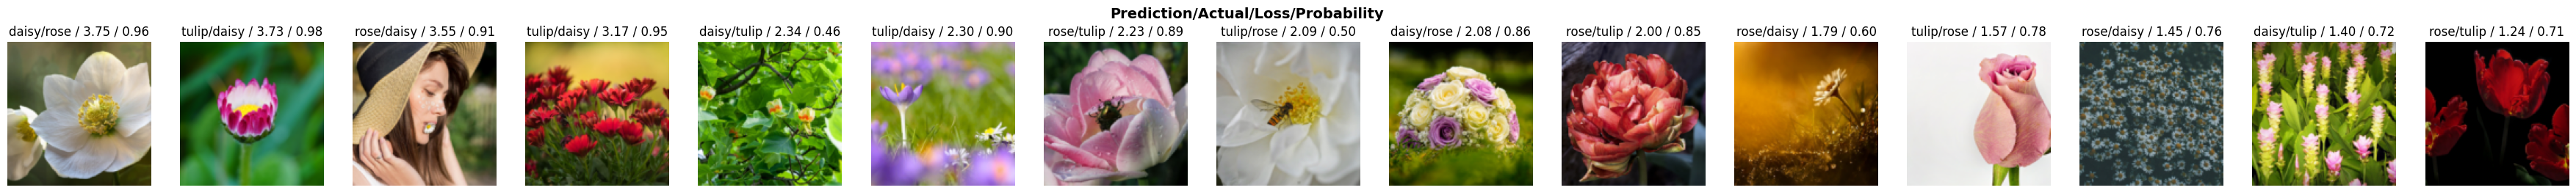

In [ ]:
interp.plot_top_losses(15, nrows=1)

In [ ]:
# Data cleaning

# cleaner = ImageClassifierCleaner(learn)
# cleaner

# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)


In [ ]:
# Exporting model
from fastai.vision.all import load_learner

learn.save('resnet18-stage-1')
learn.export('resnet18.pkl')
learn_inf = load_learner('resnet18.pkl')

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
